In [1]:
#  UX-Section Summary Initialization
EXPLAIN = True  

def banner(title, body=None):
    line = "=" * len(title)
    print(f"\n{line}\n{title}\n{line}")
    if body and EXPLAIN:
        print(body)

In [2]:
# Boostrap
from pathlib import Path
import shutil, os, re, json, subprocess, datetime
import numpy as np
import pandas as pd, re
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Patch

banner(
    "1) Bootstrap: folders & one-time migration",
    "Creates the project folders, pulls source CSV/XLSX from Desktop into the project, "
    "and migrates any legacy ./outputs into the new outputs folder."
)

PROJECT_DIR = Path("Dock Optimization Project")
DATADIR     = PROJECT_DIR / "data"
OUTDIR      = PROJECT_DIR / "outputs"
for p in (PROJECT_DIR, DATADIR, OUTDIR):
    p.mkdir(parents=True, exist_ok=True)

# One-time migration of legacy outputs
LEGACY = Path("outputs")
if LEGACY.exists():
    for p in LEGACY.glob("*"):
        if p.is_file():
            shutil.copy2(p, OUTDIR / p.name)
    print("✓ Migrated prior files from ./outputs →", OUTDIR)
else:
    print("No legacy ./outputs to migrate (ok).")

# Source locations 
DESKTOP_PATH = r"C:\Users\13346\OneDrive\Desktop"
INBOUND_NAME  = "Inbound.csv"
OUTBOUND_NAME = "outbound.csv"

# Copy project/data 
src_inb = Path(DESKTOP_PATH) / INBOUND_NAME
src_out = Path(DESKTOP_PATH) / OUTBOUND_NAME
dst_inb = DATADIR / INBOUND_NAME
dst_out = DATADIR / OUTBOUND_NAME
for s,d in [(src_inb,dst_inb),(src_out,dst_out)]:
    try:
        if s.exists() and not d.exists():
            shutil.copy2(s, d)
    except Exception as e:
        print("Skip copy:", s, "->", d, "| Reason:", e)

INBOUND_PATH  = str(dst_inb if dst_inb.exists() else src_inb)
OUTBOUND_PATH = str(dst_out if dst_out.exists() else src_out)

print("Project:", PROJECT_DIR.resolve())
print("Data   :", DATADIR.resolve())
print("Outputs:", OUTDIR.resolve())



1) Bootstrap: folders & one-time migration
Creates the project folders, pulls source CSV/XLSX from Desktop into the project, and migrates any legacy ./outputs into the new outputs folder.
✓ Migrated prior files from ./outputs → Dock Optimization Project\outputs
Project: C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\Dock Optimization Project
Data   : C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\Dock Optimization Project\data
Outputs: C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\Dock Optimization Project\outputs


In [3]:
# Parameters
banner(
    "2) Model configuration",
    "Geometry converts door separation to feet; time model uses speed and fixed per-move handling. "
    "CUBE is the primary flow metric with automatic fallback to SHIPMENTS if CUBE is all-zero on either side."
)
# Metric priority
METRIC_PRIORITY = ["cube", "shipments", "weight_lb"]

# Dock: 38×38 for MCI
N_INBOUND_DOORS  = 38
N_OUTBOUND_DOORS = 38

# Reserve last K outbound doors for city P&D
NUM_PD_OUTBOUND_DOORS = 0

# Geometry (feet)
BAY_SPACING_FT    = 12.0
AISLE_CROSSING_FT = 60.0
TURN_PENALTY_FT   = 10.0

# Time / handling model
FORKLIFT_SPEED_FT_S  = 6.0      # ~4.1 mph
SECONDS_PER_MOVE_FIX = 10.0     # pick/drop overhead per move (sec)

#  NO-CROSS windows (dimensioners / ramps) 
# Helper: enter door numbers as you see them (1..N), this converts to indices
def span_between(lo_door:int, hi_door:int, name:str, detour_ft:float=16.0):
    # a window between doors is treated as the half-open interval lo-0.5 … hi+0.5
    return (lo_door - 0.5, hi_door + 0.5, name, float(detour_ft))

#  replace the examples with actual spans from the dock layout
NO_CROSS_WINDOWS = [
    span_between(12, 16, "DIM-1", 16.0),
    span_between(23, 27, "DIM-2", 16.0),
    span_between(33, 34, "DIM-3", 16.0),
]

# Trailer sanity checks
LINEHAUL_CAP_LB = 22000  # 48ft pups
PD_CAP_LB       = 48000  # 53ft P&D

MCI_CODE = "MCI"



2) Model configuration
Geometry converts door separation to feet; time model uses speed and fixed per-move handling. CUBE is the primary flow metric with automatic fallback to SHIPMENTS if CUBE is all-zero on either side.


In [4]:
# Load and Normalize
banner(
    "3) Load & normalize",
    "Reads your Inbound/Outbound files; detects lane/date/cube/shipments/weight columns; "
    "converts dates; filters to MCI: FROM MCI for outbound (types O/B), TO MCI for inbound (types D/B)."
)

def read_any(path: str) -> pd.DataFrame:
    p = Path(path)
    if p.suffix.lower() in (".xlsx",".xls"):
        try:
            return pd.read_excel(path)
        except Exception:
            return pd.read_excel(path, engine="openpyxl")
    # CSV read
    for enc in ("utf-8-sig","utf-8","latin-1"):
        for args in (dict(sep=None, engine="python"), dict()):
            try:
                return pd.read_csv(path, encoding=enc, **args)
            except Exception:
                pass
    return pd.read_csv(path)

inb_raw = read_any(INBOUND_PATH)
out_raw = read_any(OUTBOUND_PATH)

def parse_date_series(s: pd.Series) -> pd.Series:
    parsed = pd.to_datetime(s, errors="coerce")
    if parsed.isna().mean() > 0.5:
        s2 = s.astype(str).str.replace(r"[^0-9]","", regex=True)
        parsed2 = pd.to_datetime(s2, format="%Y%m%d", errors="coerce")
        return parsed2
    return parsed

def detect_lane_column(df: pd.DataFrame, is_outbound: bool):
    pats = [r"lane", r"\bdst\b|dest|destination|terminal|\bsc\b|hub"] if is_outbound \
           else [r"lane", r"\bori\b|origin|load.?ori|terminal|\bsc\b|hub"]
    for ptn in pats:
        for c in df.columns:
            if re.search(ptn, str(c).lower()): return c
    return None

def detect_date_column(df: pd.DataFrame, prefer_regexes):
    cands=[]
    for c in df.columns:
        lc = str(c).lower()
        if any(re.search(rgx, lc) for rgx in prefer_regexes) or ("date" in lc or lc.endswith("dt")):
            parsed = parse_date_series(df[c])
            if (1.0 - float(parsed.isna().mean())) >= 0.2:
                cands.append((float(parsed.isna().mean()), c))
    if not cands: return None
    cands.sort(key=lambda x: x[0])
    return cands[0][1]

def pick_cube(df):      # Map CUBE columns
    for c in df.columns:
        if re.search(r"\bcube\b", str(c), flags=re.I): return c
def pick_ship(df):      # Map SHIPMENTS
    for c in df.columns:
        if re.search(r"shipments?|pro.*count|sfx_pro_count|cb_pro_count", str(c), flags=re.I): return c
def pick_weight(df):    # Map WEIGHT
    for c in df.columns:
        if re.search(r"weight|wt|lbs?", str(c), flags=re.I): return c
    return None

def normalize_frames(inb_raw: pd.DataFrame, out_raw: pd.DataFrame):
    inb_lane = detect_lane_column(inb_raw, is_outbound=False)
    out_lane = detect_lane_column(out_raw, is_outbound=True)
    inb_date = detect_date_column(inb_raw, [r"pu.*date|pickup", r"arriv", r"inb.*date"])
    out_date = detect_date_column(out_raw, [r"dispatch.*date|dispatch.*dt", r"load.*date|load.*dt",
                                            r"out.*date|out.*dt", r"dep.*date|dep.*dt"])

    inb_cube, out_cube = pick_cube(inb_raw), pick_cube(out_raw)
    inb_ship, out_ship = pick_ship(inb_raw), pick_ship(out_raw)
    inb_w, out_w       = pick_weight(inb_raw), pick_weight(out_raw)

    rn = lambda df, m: df.rename(columns={k:v for k,v in m.items() if k})

    inb = rn(inb_raw, {inb_lane:"INB_LANE", inb_date:"INB_DATE",
                       inb_cube:"INB_CUBE", inb_ship:"INB_SHIPMENTS", inb_w:"INB_WEIGHT_LB"})
    out = rn(out_raw, {out_lane:"OUT_LANE", out_date:"OUT_DATE",
                       out_cube:"OUT_CUBE", out_ship:"OUT_SHIPMENTS", out_w:"OUT_WEIGHT_LB"})

    if "INB_DATE" in inb.columns: inb["INB_DATE"] = parse_date_series(inb["INB_DATE"])
    if "OUT_DATE" in out.columns: out["OUT_DATE"] = parse_date_series(out["OUT_DATE"])

    # Ensure numeric
    for c in ("INB_CUBE","INB_SHIPMENTS","INB_WEIGHT_LB"):
        if c not in inb.columns: inb[c] = 0.0
        inb[c] = pd.to_numeric(inb[c], errors="coerce").fillna(0.0)
    for c in ("OUT_CUBE","OUT_SHIPMENTS","OUT_WEIGHT_LB"):
        if c not in out.columns: out[c] = 0.0
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0.0)

    # Filter to MCI logic
    def _find(df, patterns):
        for c in df.columns:
            if any(re.search(p, str(c).lower()) for p in patterns):
                return c
        return None
    out_ori_sc   = _find(out, [r"\borigin\b", r"\bori(_sc)?\b", r"from[_\s-]*sc", r"from[_\s-]*term"])
    out_ori_type = _find(out, [r"ori.*type"])
    inb_dst_sc   = _find(inb, [r"\bdest(ination)?\b", r"\bdst(_sc)?\b", r"to[_\s-]*sc", r"to[_\s-]*term"])
    inb_dst_type = _find(inb, [r"dst.*type"])

    # Outbound legs that DEPART from MCI (Type O/B)
    if out_ori_sc is not None:
        mask_out = out[out_ori_sc].astype(str).str.upper().eq(MCI_CODE)
        if out_ori_type is not None:
            mask_out &= out[out_ori_type].astype(str).str.upper().isin(["O","B"])
        out = out.loc[mask_out].copy()

    # Inbound legs that ARRIVE to MCI (Type D/B)
    if inb_dst_sc is not None:
        mask_in = inb[inb_dst_sc].astype(str).str.upper().eq(MCI_CODE)
        if inb_dst_type is not None:
            mask_in &= inb[inb_dst_type].astype(str).str.upper().isin(["B","D"])
        inb = inb.loc[mask_in].copy()

    print("Detected:", {
        "INB_LANE": inb_lane, "INB_DATE": inb_date, "INB_CUBE": inb_cube, "INB_SHIPMENTS": inb_ship, "INB_WEIGHT_LB": inb_w,
        "OUT_LANE": out_lane, "OUT_DATE": out_date, "OUT_CUBE": out_cube, "OUT_SHIPMENTS": out_ship, "OUT_WEIGHT_LB": out_w
    })
    print(f"Rows after MCI filter → inbound: {len(inb):,} | outbound: {len(out):,}")
    return inb, out

inb_df, out_df = normalize_frames(inb_raw, out_raw)


3) Load & normalize
Reads your Inbound/Outbound files; detects lane/date/cube/shipments/weight columns; converts dates; filters to MCI: FROM MCI for outbound (types O/B), TO MCI for inbound (types D/B).
Detected: {'INB_LANE': 'LANE_ID', 'INB_DATE': 'PU DATE', 'INB_CUBE': 'CUBE', 'INB_SHIPMENTS': 'SHIPMENTS', 'INB_WEIGHT_LB': None, 'OUT_LANE': 'LANE_ID', 'OUT_DATE': 'PU_DATE', 'OUT_CUBE': 'CUBE', 'OUT_SHIPMENTS': 'SHIPMENTS', 'OUT_WEIGHT_LB': None}
Rows after MCI filter → inbound: 9,157 | outbound: 8,077


In [5]:
# Flow Matrix
banner(
    "4) Build flow matrix (CUBE preferred) with robust date matching",
    "Within each day I allocated inbound volume to outbound lanes proportionally by the outbound totals. "
    "If same-day matches are sparse we allow ±1 day, then weekly buckets, else a whole-window proportional fallback."
)

def choose_metric(inb: pd.DataFrame, out: pd.DataFrame, priority):
    totals = {
        "cube":      (inb.get("INB_CUBE", pd.Series([0])).sum(),      out.get("OUT_CUBE", pd.Series([0])).sum()),
        "shipments": (inb.get("INB_SHIPMENTS", pd.Series([0])).sum(), out.get("OUT_SHIPMENTS", pd.Series([0])).sum()),
        "weight_lb": (inb.get("INB_WEIGHT_LB", pd.Series([0])).sum(), out.get("OUT_WEIGHT_LB", pd.Series([0])).sum()),
    }
    for m in priority:
        a,b = totals[m]
        if a>0 and b>0:
            print(f"Selected metric: {m} (INB={a:,.0f}, OUT={b:,.0f})")
            return m
    return priority[-1]

metric_choice = choose_metric(inb_df, out_df, METRIC_PRIORITY)

def build_flow_matrix(inb: pd.DataFrame, out: pd.DataFrame, metric="cube"):
    im, om = {"cube":("INB_CUBE","OUT_CUBE"),
              "shipments":("INB_SHIPMENTS","OUT_SHIPMENTS"),
              "weight_lb":("INB_WEIGHT_LB","OUT_WEIGHT_LB")}[metric]
    inb2 = inb.dropna(subset=["INB_LANE","INB_DATE"]).copy()
    out2 = out.dropna(subset=["OUT_LANE","OUT_DATE"]).copy()

    def same_day():
        a = inb2.groupby([pd.Grouper(key="INB_DATE", freq="D"), "INB_LANE"])[im].sum().reset_index()
        b = out2.groupby([pd.Grouper(key="OUT_DATE", freq="D"), "OUT_LANE"])[om].sum().reset_index()
        return a.merge(b, left_on="INB_DATE", right_on="OUT_DATE", how="inner")

    def pm_one():
        a = inb2.copy(); b = out2.copy()
        a["INB_D"] = a["INB_DATE"].dt.floor("D"); b["OUT_D"] = b["OUT_DATE"].dt.floor("D")
        a = a.groupby(["INB_D","INB_LANE"])[im].sum().reset_index()
        b = b.groupby(["OUT_D","OUT_LANE"])[om].sum().reset_index()
        a["key"]=1; b["key"]=1
        cart = a.merge(b,on="key").drop(columns="key")
        cart = cart[(cart["OUT_D"]-cart["INB_D"]).abs()<=pd.Timedelta(days=1)]
        return cart.rename(columns={"INB_D":"INB_DATE","OUT_D":"OUT_DATE"})

    def weekly():
        a = inb2.copy(); b = out2.copy()
        a["W"] = a["INB_DATE"].dt.to_period("W").dt.start_time
        b["W"] = b["OUT_DATE"].dt.to_period("W").dt.start_time
        a = a.groupby(["W","INB_LANE"])[im].sum().reset_index().rename(columns={"W":"INB_DATE"})
        b = b.groupby(["W","OUT_LANE"])[om].sum().reset_index().rename(columns={"W":"OUT_DATE"})
        return a.merge(b, left_on="INB_DATE", right_on="OUT_DATE", how="inner")

    merged = same_day()
    if merged.empty: merged = pm_one()
    if merged.empty: merged = weekly()

    if merged.empty:
        it = inb2.groupby("INB_LANE")[im].sum().rename("INB_T").reset_index()
        ot = out2.groupby("OUT_LANE")[om].sum().rename("OUT_T").reset_index()
        ot["OUT_SHARE"] = ot["OUT_T"] / max(ot["OUT_T"].sum(),1e-9)
        it["key"]=1; ot["key"]=1
        x = it.merge(ot,on="key").drop(columns="key")
        x["FLOW"] = x["INB_T"] * x["OUT_SHARE"]
        return x.pivot_table(index="INB_LANE", columns="OUT_LANE", values="FLOW",
                             aggfunc="sum", fill_value=0.0)

    merged["OUT_TOTAL"] = merged.groupby("OUT_DATE")[om].transform("sum").replace(0, np.nan)
    merged["PROP"] = merged[om] / merged["OUT_TOTAL"]
    merged["FLOW"] = merged[im] * merged["PROP"]
    return merged.pivot_table(index="INB_LANE", columns="OUT_LANE", values="FLOW",
                              aggfunc="sum", fill_value=0.0)

F_df = build_flow_matrix(inb_df, out_df, metric_choice)
F_df.to_csv(OUTDIR / f"flow_matrix_{metric_choice}.csv", encoding="utf-8")
print("✓ Flow matrix:", F_df.shape, "→", OUTDIR / f"flow_matrix_{metric_choice}.csv")


4) Build flow matrix (CUBE preferred) with robust date matching
Within each day I allocated inbound volume to outbound lanes proportionally by the outbound totals. If same-day matches are sparse we allow ±1 day, then weekly buckets, else a whole-window proportional fallback.
Selected metric: cube (INB=1,032,450, OUT=907,701)
✓ Flow matrix: (2000, 1969) → Dock Optimization Project\outputs\flow_matrix_cube.csv



5) Select best 38×38 submatrix (max coverage)
Picks the 38 FROM and 38 TO lanes that capture the most flow mass overall. This is what I optimized on for door placement.
✓ Selected 38×38 | captured=229.06 (12.30% of total)
✓ Saved: Dock Optimization Project\outputs\heatmap_38x38_log.png


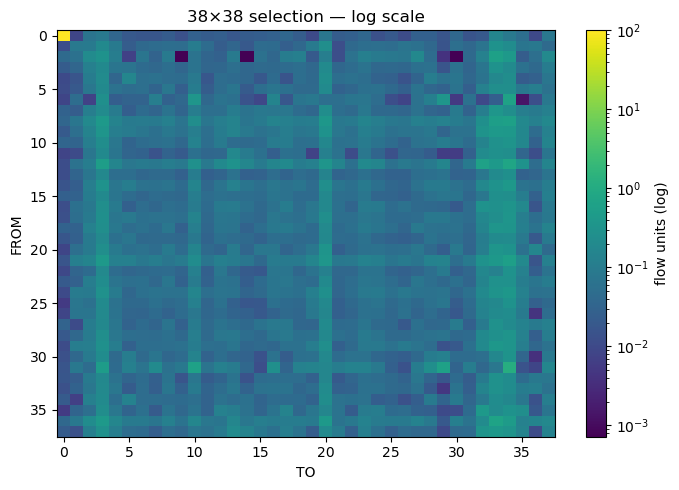

In [6]:
banner(
    "5) Select best 38×38 submatrix (max coverage)",
    "Picks the 38 FROM and 38 TO lanes that capture the most flow mass overall. "
    "This is what I optimized on for door placement."
)

def select_max_coverage(F: np.ndarray, rmax: int, cmax: int):
    m,n = F.shape
    cells = np.dstack(np.unravel_index(np.argsort(F.ravel())[::-1], (m,n)))[0]
    R,C=set(),set()
    for i,j in cells:
        if F[i,j]>0: R.add(i); C.add(j); break
    def gain_row(i): return float(F[i, list(C)].sum()) if C else float(F[i,:].max())
    def gain_col(j): return float(F[list(R), j].sum()) if R else float(F[:,j].max())
    while len(R)<rmax or len(C)<cmax:
        best_r=(-1,-1.0); best_c=(-1,-1.0)
        if len(R)<rmax:
            for i in range(m):
                if i in R: continue
                g=gain_row(i)
                if g>best_r[1]: best_r=(i,g)
        if len(C)<cmax:
            for j in range(n):
                if j in C: continue
                g=gain_col(j)
                if g>best_c[1]: best_c=(j,g)
        if best_r[1]<=0 and best_c[1]<=0:
            for i,j in cells:
                if ((i not in R and len(R)<rmax) or (j not in C and len(C)<cmax)):
                    if i not in R and len(R)<rmax: R.add(i)
                    if j not in C and len(C)<cmax: C.add(j)
                    break
            else: break
        else:
            if (best_r[1]>=best_c[1] and len(R)<rmax) or len(C)>=cmax:
                R.add(best_r[0])
            else:
                C.add(best_c[0])
    return sorted(R)[:rmax], sorted(C)[:cmax]

F_full = F_df.values.astype(float)
R_sel, C_sel = select_max_coverage(F_full, N_INBOUND_DOORS, N_OUTBOUND_DOORS)
F_use_df = F_df.iloc[R_sel, C_sel].copy()
F = F_use_df.values.astype(float)
INB_ORDER = list(F_use_df.index)   # FROM (to MCI)
OUT_ORDER = list(F_use_df.columns) # TO (from MCI)

captured = float(F.sum())
coverage_pct = 100*captured/max(F_full.sum(),1e-9)
print(f"✓ Selected 38×38 | captured={captured:,.2f} ({coverage_pct:.2f}% of total)")

# Heatmaps for review
arr = F.astype(float)
plt.figure(figsize=(7,5))
eps = max(arr[arr>0].min(), 1e-9) if (arr>0).any() else 1e-9
plt.imshow(arr+eps, aspect="auto", norm=LogNorm(vmin=eps, vmax=arr.max()+eps))
plt.colorbar(label="flow units (log)")
plt.title("38×38 selection — log scale")
plt.xlabel("TO"); plt.ylabel("FROM")
plt.tight_layout(); plt.savefig(OUTDIR/"heatmap_38x38_log.png", dpi=180, bbox_inches="tight")
print("✓ Saved:", OUTDIR/"heatmap_38x38_log.png")


In [7]:
# Distance Matrix
banner(
    "6) Distance matrix (feet)",
    "Manhattan-style distance model: crossing the main aisle + along-dock distance + turn penalty."
)

def build_distance_matrix(n_in:int, n_out:int, bay:float, cross:float, turn:float,
                          windows=None) -> np.ndarray:
    P = np.arange(n_in).reshape(-1,1)     # inbound door indices (0..n_in-1)
    Q = np.arange(n_out).reshape(1,-1)    # outbound door indices (0..n_out-1)
    D = cross + np.abs(P - Q)*bay + turn  # base Manhattan distance

    # add detours for any window the path would cross
    if windows:
        for (blo, bhi, _name, detour) in windows:
            crosses = (np.minimum(P, Q) <= bhi) & (np.maximum(P, Q) >= blo)
            D = D + detour * crosses.astype(float)
    return D

# call it WITH windows
D = build_distance_matrix(
    N_INBOUND_DOORS, N_OUTBOUND_DOORS,
    BAY_SPACING_FT, AISLE_CROSSING_FT, TURN_PENALTY_FT,
    windows=NO_CROSS_WINDOWS
)


6) Distance matrix (feet)
Manhattan-style distance model: crossing the main aisle + along-dock distance + turn penalty.


In [8]:
# Optimizer
banner(
    "7) Optimize door assignments",
    "Objective: minimize J(π,σ)=Σ F_ij·d(π(i),σ(j)) with optional soft penalties: "
    "congestion smoothing and keep-similar-lanes-close. Hungarian + local swap polish."
)

# Secondary effects (set >0 to emphasize)
LAMBDA_CONG_IN  = 0.00
LAMBDA_CONG_OUT = 0.02
LAMBDA_IN_CLUSTER  = 0.00
LAMBDA_OUT_CLUSTER = 0.03
DENSITY_WINDOW  = 3

S_in  = F @ F.T
S_out = F.T @ F
_BAY  = BAY_SPACING_FT

def door_workloads(F, pin, pout):
    Win  = F.sum(axis=1)[pin]
    Wout = F.sum(axis=0)[pout]
    return Win, Wout

def density(vec, window=3):
    return np.convolve(vec, np.ones(window), mode="same")

def congestion_penalty(F, pin, pout):
    Win, Wout = door_workloads(F, pin, pout)
    din, dout = density(Win, DENSITY_WINDOW), density(Wout, DENSITY_WINDOW)
    return LAMBDA_CONG_IN*np.dot(din,din) + LAMBDA_CONG_OUT*np.dot(dout,dout)

def cluster_penalty(pin, pout):
    add=0.0
    if LAMBDA_IN_CLUSTER>0:
        for a in range(len(pin)):
            for b in range(a+1,len(pin)):
                add += S_in[a,b]*abs(pin[a]-pin[b])*_BAY
    if LAMBDA_OUT_CLUSTER>0:
        for a in range(len(pout)):
            for b in range(a+1,len(pout)):
                add += S_out[a,b]*abs(pout[a]-pout[b])*_BAY
    return add

def augmented_objective(F, D, pin, pout):
    return float((F * D[np.ix_(pin, pout)]).sum()) + congestion_penalty(F,pin,pout) + cluster_penalty(pin,pout)

try:
    from scipy.optimize import linear_sum_assignment
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

def hungarian_or_greedy(cost):
    if SCIPY_OK:
        r,c = linear_sum_assignment(cost)
        perm = np.zeros_like(r); perm[r]=c
        return perm
    # greedy fallback
    n_rows, n_cols = cost.shape
    perm = -np.ones(n_rows, dtype=int); used=set()
    order = np.argsort(cost.min(axis=1))
    for r in order:
        tmp = cost[r].copy()
        if used: tmp[list(used)] = np.inf
        j = int(np.argmin(tmp))
        perm[r]=j; used.add(j)
    return perm

def inbound_cost(F, D, pout): return F @ D[:, pout].T
def outbound_cost(F, D, pin): return F.T @ D[pin, :]

def polish_swaps(F, D, pin, pout, side="inbound", passes=2):
    cur = augmented_objective(F,D,pin,pout)
    for _ in range(passes):
        improved=False
        if side=="inbound":
            for a in range(len(pin)):
                for b in range(a+1,len(pin)):
                    p=pin.copy(); p[a],p[b]=p[b],p[a]
                    val=augmented_objective(F,D,p,pout)
                    if val+1e-9<cur: pin=p; cur=val; improved=True
        else:
            for a in range(len(pout)):
                for b in range(a+1,len(pout)):
                    q=pout.copy(); q[a],q[b]=q[b],q[a]
                    val=augmented_objective(F,D,pin,q)
                    if val+1e-9<cur: pout=q; cur=val; improved=True
        if not improved: break
    return pin, pout, cur

def optimize(F, D, iters=8, reserve_pd_out=NUM_PD_OUTBOUND_DOORS):
    pin  = np.arange(min(F.shape[0], D.shape[0]))
    pout = np.arange(min(F.shape[1], D.shape[1]))
    hist=[]
    for _ in range(iters):
        Ci = inbound_cost(F,D,pout); pin  = hungarian_or_greedy(Ci)
        Co = outbound_cost(F,D, pin)

        # Reserve last K outbound doors for “P&D-eligible” lanes (highest outbound totals)
        if reserve_pd_out>0:
            reserved = list(range(D.shape[1]-reserve_pd_out, D.shape[1]))
            out_tot = F.sum(axis=0)
            pd_eligible = set(np.argsort(out_tot)[-reserve_pd_out:])
            big = 1e9
            for j in range(Co.shape[0]):
                if j not in pd_eligible:
                    Co[j, reserved] += big

        pout = hungarian_or_greedy(Co)
        pin, pout, o = polish_swaps(F,D,pin,pout,"inbound",2)
        pin, pout, o = polish_swaps(F,D,pin,pout,"outbound",2)
        hist.append(o)
    return pin, pout, hist

perm_in_opt, perm_out_opt, history = optimize(F, D, iters=8)


7) Optimize door assignments
Objective: minimize J(π,σ)=Σ F_ij·d(π(i),σ(j)) with optional soft penalties: congestion smoothing and keep-similar-lanes-close. Hungarian + local swap polish.


In [9]:
# Metrics
banner(
    "8) Executive math proof",
    "We compare: (a) door index = row/col identity (baseline) vs (b) optimized permutations. "
    "We report feet and time equivalents. The math report is written to JSON + Markdown."
)

def compute_metrics(F, D, pin, pout):
    dist = float((F * D[np.ix_(pin, pout)]).sum())
    units = float(F.sum())
    seconds = (dist / max(FORKLIFT_SPEED_FT_S,1e-6)) + units*SECONDS_PER_MOVE_FIX
    return dict(total_distance_ft=dist, total_units=units, estimated_seconds=seconds)

base = compute_metrics(F, D, np.arange(F.shape[0]), np.arange(F.shape[1]))
opt  = compute_metrics(F, D, perm_in_opt, perm_out_opt)

savings_ft  = base["total_distance_ft"] - opt["total_distance_ft"]
savings_pct = 100.0 * savings_ft / max(base["total_distance_ft"], 1e-9)
savings_hrs = (savings_ft / max(FORKLIFT_SPEED_FT_S,1e-6)) / 3600.0

print(f"Baseline distance (ft):  {base['total_distance_ft']:.0f}")
print(f"Optimized distance (ft): {opt['total_distance_ft']:.0f}")
print(f"Savings: {savings_ft:,.0f} ft ({savings_pct:.2f}%)  ≈ {savings_hrs:.2f} travel hours")

# Persist math report
report = {
    "config": {
        "N_INBOUND_DOORS": N_INBOUND_DOORS,
        "N_OUTBOUND_DOORS": N_OUTBOUND_DOORS,
        "BAY_SPACING_FT": BAY_SPACING_FT,
        "AISLE_CROSSING_FT": AISLE_CROSSING_FT,
        "TURN_PENALTY_FT": TURN_PENALTY_FT,
        "FORKLIFT_SPEED_FT_S": FORKLIFT_SPEED_FT_S,
        "SECONDS_PER_MOVE_FIX": SECONDS_PER_MOVE_FIX
    },
    "metric_used": metric_choice,
    "baseline": base,
    "optimized": opt,
    "savings": {"distance_ft": float(savings_ft), "percent": float(savings_pct),
                "travel_hours_equiv": float(savings_hrs)},
    "history": [float(x) for x in history],
}
with open(OUTDIR/"math_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

with open(OUTDIR/"math_report.md", "w", encoding="utf-8") as f:
    f.write(
f"""# Dock Layout Optimization — Math Proof (MCI)

**Objective**  
J(π,σ) = Σᵢ Σⱼ Fᵢⱼ · d(π(i), σ(j))

**Distance model**  
d(p,q) = {AISLE_CROSSING_FT} + {BAY_SPACING_FT}·|p−q| + {TURN_PENALTY_FT} (ft)

**Time model**  
t(p,q) = d(p,q)/{FORKLIFT_SPEED_FT_S} + {SECONDS_PER_MOVE_FIX}  (seconds per move)

## Results
- Baseline total distance (ft): {base['total_distance_ft']:.0f}
- Optimized total distance (ft): {opt['total_distance_ft']:.0f}
- Distance saved (ft): {savings_ft:.0f}  ({savings_pct:.2f}%)
- Travel-time savings (hrs): {savings_hrs:.2f}

All artifacts are in: `{OUTDIR}`.
""")
print("✓ Math report →", OUTDIR/"math_report.{json,md}")

# Save optimized assignments
pd.DataFrame({"INB_LANE": INB_ORDER, "INB_DOOR": (perm_in_opt + 1)}).to_csv(OUTDIR/"optimized_inbound_assignments.csv", index=False, encoding="utf-8")
pd.DataFrame({"OUT_LANE": OUT_ORDER, "OUT_DOOR": (perm_out_opt + 1)}).to_csv(OUTDIR/"optimized_outbound_assignments.csv", index=False, encoding="utf-8")

# Pairwise contributions (for audit)
D_sub_base = D[np.ix_(np.arange(F.shape[0]), np.arange(F.shape[1]))]
D_sub_opt  = D[np.ix_(perm_in_opt, perm_out_opt)]
base_pairs = pd.DataFrame(F * D_sub_base, index=INB_ORDER, columns=OUT_ORDER).stack().rename("distance_ft_contrib").reset_index().rename(columns={"level_0":"INB_LANE","level_1":"OUT_LANE"})
opt_pairs  = pd.DataFrame(F * D_sub_opt,  index=INB_ORDER, columns=OUT_ORDER).stack().rename("distance_ft_contrib").reset_index().rename(columns={"level_0":"INB_LANE","level_1":"OUT_LANE"})
base_pairs["flow_units"] = pd.DataFrame(F, index=INB_ORDER, columns=OUT_ORDER).stack().values
opt_pairs["flow_units"]  = pd.DataFrame(F, index=INB_ORDER, columns=OUT_ORDER).stack().values
base_pairs.sort_values("distance_ft_contrib", ascending=False).to_csv(OUTDIR/"pairwise_contrib_baseline.csv", index=False, encoding="utf-8")
opt_pairs.sort_values("distance_ft_contrib",  ascending=False).to_csv(OUTDIR/"pairwise_contrib_optimized.csv", index=False, encoding="utf-8")


8) Executive math proof
We compare: (a) door index = row/col identity (baseline) vs (b) optimized permutations. We report feet and time equivalents. The math report is written to JSON + Markdown.
Baseline distance (ft):  39272
Optimized distance (ft): 33764
Savings: 5,508 ft (14.02%)  ≈ 0.25 travel hours
✓ Math report → Dock Optimization Project\outputs\math_report.{json,md}



9) Dock diagram, aligned clusters (color-coded), break doors & DIM bars
Colors show clusters. FROM (bottom) and TO (top) share the same palette after alignment. Break doors mark high-throughput seams. DIM bars mark no-cross areas.
✓ Colored layout with aligned clusters → C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\Dock Optimization Project\outputs\dock_layout_MCI_clusters.png
✓ Door labels + cluster ids → C:\Users\13346\Dock Optimization Project\outputs\Dock Optimization Project\Dock Optimization Project\Dock Optimization Project\outputs\door_labels_MCI_clusters.csv
✓ Cluster alignment → Dock Optimization Project\outputs\cluster_alignment.csv


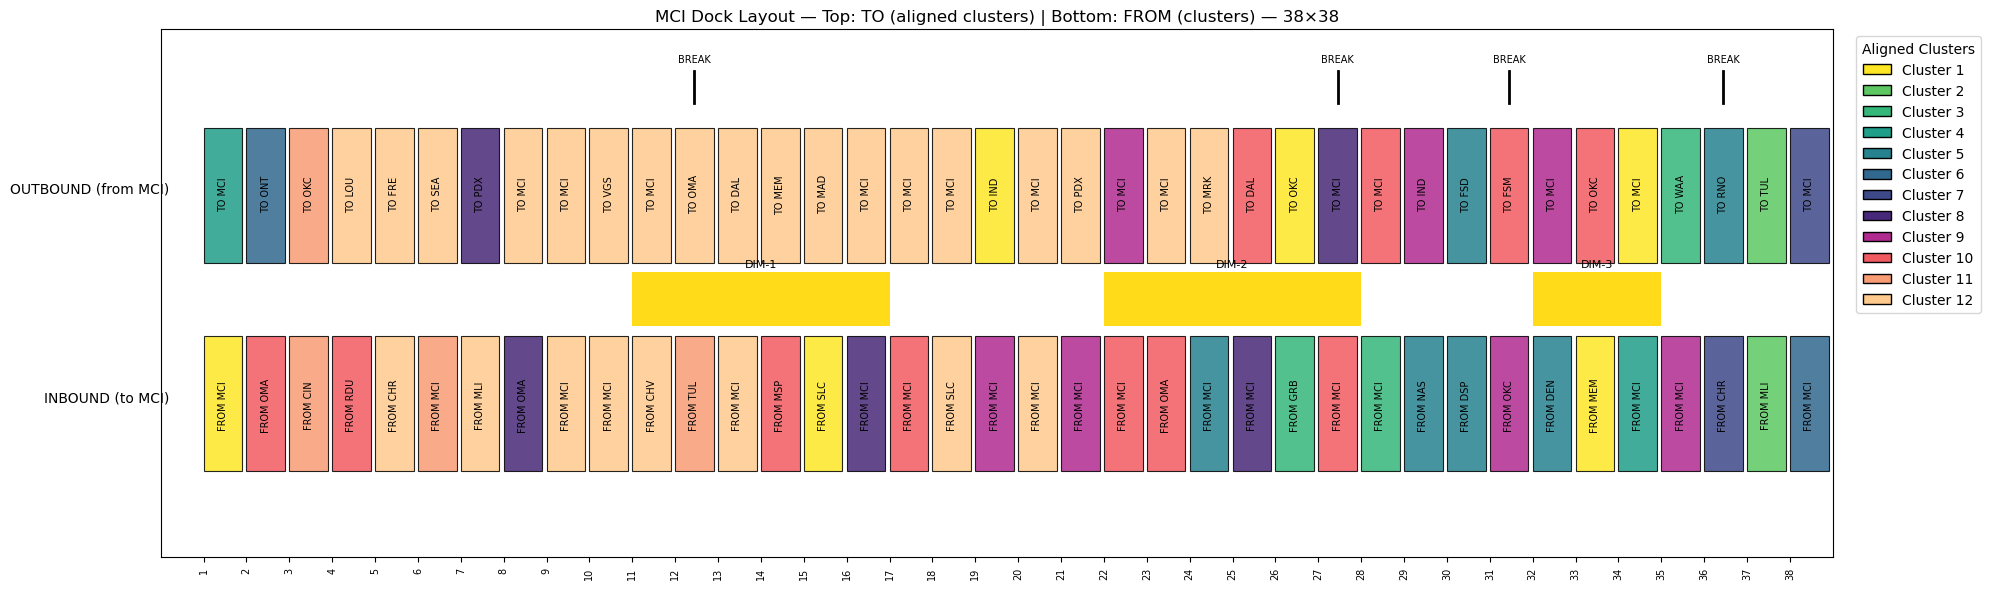

In [10]:
banner(
    "9) Dock diagram, aligned clusters (color-coded), break doors & DIM bars",
    "Colors show clusters. FROM (bottom) and TO (top) share the same palette after alignment. "
    "Break doors mark high-throughput seams. DIM bars mark no-cross areas."
)

# Helpers 
def _spectral_order(S: np.ndarray) -> np.ndarray:
    """1D seriation by leading eigenvector (robust for symmetric nonneg matrices)."""
    if S.size == 0: 
        return np.arange(0)
    # eigh returns ascending eigenvalues/eigenvectors
    vals, vecs = np.linalg.eigh(S)
    z = vecs[:, -1]  # principal axis
    return np.argsort(z)

def _segments_from_order(order: np.ndarray, S: np.ndarray, K: int=None, q: float=0.30, min_seg: int=1):
    """
    Given an order and similarity matrix S, return contiguous segments.
    If K is None -> cut where adjacency similarity is in lowest q-quantile.
    """
    n = len(order)
    if n <= 1:
        return [(0, n)]
    sims = np.array([S[order[i], order[i+1]] for i in range(n-1)], dtype=float)

    if K is None:
        thr = np.quantile(sims, q) if sims.size else np.inf
        cuts = [i+1 for i, s in enumerate(sims) if s <= thr]
    else:
        K = max(1, min(K, n))
        if K == 1: 
            cuts = []
        else:
            cuts = list(np.argsort(sims)[:K-1] + 1)
            cuts.sort()

    segs = []
    start = 0
    for c in cuts:
        if c - start >= min_seg:
            segs.append((start, c))
            start = c
    if start < n:
        segs.append((start, n))

    # Merge any 1-wide leftovers into neighbors
    merged = []
    for s,e in segs:
        if (e - s) >= min_seg or not merged:
            merged.append((s,e))
        else:
            ps,pe = merged.pop()
            merged.append((ps,e))
    return merged

def _cluster_ids_from_segments(order: np.ndarray, segments):
    """
    Return an int array cluster_id where id in {1..K}. Positions follow original index space.
    """
    n = len(order)
    cid = np.zeros(n, dtype=int)
    for k,(s,e) in enumerate(segments, start=1):
        idx = order[s:e]
        cid[idx] = k
    # guard: anything still zero -> put into last cluster
    if (cid == 0).any():
        cid[cid == 0] = int(cid.max() if cid.max() > 0 else 1)
    return cid

def _align_to_clusters(F: np.ndarray, row_cluster: np.ndarray, col_cluster: np.ndarray):
    """
    Build block flow matrix B[a,b] and align TO clusters to FROM clusters
    by solving an assignment that maximizes diagonal flow.
    Returns:
        mapping: dict {to_cluster -> aligned_from_cluster}
        Bmat:    block totals
    """
    A = int(row_cluster.max())
    B = int(col_cluster.max())
    Bmat = np.zeros((A, B), dtype=float)
    for a in range(1, A+1):
        r_idx = np.where(row_cluster == a)[0]
        if r_idx.size == 0: 
            continue
        rowsum = F[r_idx, :]
        for b in range(1, B+1):
            c_idx = np.where(col_cluster == b)[0]
            if c_idx.size == 0: 
                continue
            Bmat[a-1, b-1] = float(rowsum[:, c_idx].sum())

    # Assignment (maximize) → minimize negative cost
    try:
        from scipy.optimize import linear_sum_assignment
        cost = -Bmat.copy()
        # pad to square if needed (keeps unmatched clusters as free)
        Amax = max(Bmat.shape)
        pad = np.zeros((Amax, Amax))
        pad[:A, :B] = cost
        r, c = linear_sum_assignment(pad)
        pairs = [(ri+1, ci+1) for ri,ci in zip(r,c) if ri < A and ci < B]
    except Exception:
        # greedy fallback
        flat = [((i//B)+1, (i % B)+1, v) for i,v in enumerate(Bmat.ravel())]
        flat.sort(key=lambda x: -x[2])
        used_r, used_c, pairs = set(), set(), []
        for a,b,_ in flat:
            if a in used_r or b in used_c: 
                continue
            pairs.append((a,b))
            used_r.add(a); used_c.add(b)
            if len(used_r) == min(A,B):
                break

    mapping = {b:a for (a,b) in pairs}  # TO cluster b → aligned FROM cluster a
    return mapping, Bmat

# Compute clusters (FROM & TO)
S_in  = F @ F.T          # FROM similarities
S_out = F.T @ F          # TO similarities

order_in  = _spectral_order(S_in)
order_out = _spectral_order(S_out)

# Choose segments automatically by 30% weakest adjacencies (tweak q if needed)
seg_in  = _segments_from_order(order_in,  S_in,  K=None, q=0.30, min_seg=1)
seg_out = _segments_from_order(order_out, S_out, K=None, q=0.30, min_seg=1)

row_cluster = _cluster_ids_from_segments(order_in,  seg_in)   # length = n_in lanes
col_cluster = _cluster_ids_from_segments(order_out, seg_out)  # length = n_out lanes

# Align TO cluster labels to FROM clusters by total flow between blocks
to2from_map, Bmat = _align_to_clusters(F, row_cluster, col_cluster)

# Create TO cluster labels *after* alignment; unmatched TO clusters get new ids after A
A = int(row_cluster.max())
col_cluster_aligned = np.zeros_like(col_cluster)
extra = 0
for b in range(1, int(col_cluster.max())+1):
    j_idx = (col_cluster == b)
    if b in to2from_map:             # map to a FROM cluster id
        col_cluster_aligned[j_idx] = to2from_map[b]
    else:                            # give a new id past A (rare)
        extra += 1
        col_cluster_aligned[j_idx] = A + extra

# Cluster ids per *door index* (convert from lane index)
# inv mappings: door_index -> F row/col index
inv_in  = np.empty_like(perm_in_opt);  inv_in[perm_in_opt]   = np.arange(len(INB_ORDER))
inv_out = np.empty_like(perm_out_opt); inv_out[perm_out_opt] = np.arange(len(OUT_ORDER))

# For each door, which cluster?
in_cluster_per_door  = row_cluster[inv_in]            # bottom row (FROM)
out_cluster_per_door = col_cluster_aligned[inv_out]   # top row (TO, aligned!)

# Labels (unchanged)
def partner_label_from_lane(lane, side, mci=MCI_CODE):
    s = str(lane).upper()
    toks = [t for t in re.split(r"[^A-Z0-9]+", s) if t]
    if not toks:
        return f"{'TO' if side=='out' else 'FROM'} ?"
    if side == "out":
        if len(toks)>=2 and toks[0]==mci: partner = toks[1]
        elif mci in toks and toks.index(mci) < len(toks)-1: partner = toks[toks.index(mci)+1]
        else: partner = toks[-1]
        return f"TO {partner}"
    else:
        if len(toks)>=2 and toks[-1]==mci: partner = toks[-2]
        elif mci in toks and toks.index(mci) > 0: partner = toks[toks.index(mci)-1]
        else: partner = toks[0]
        return f"FROM {partner}"

in_door_to_lane_raw  = [INB_ORDER[i] for i in np.argsort(perm_in_opt)]   # bottom
out_door_to_lane_raw = [OUT_ORDER[j] for j in np.argsort(perm_out_opt)]  # top
in_labels  = [partner_label_from_lane(x, "in")  for x in in_door_to_lane_raw]
out_labels = [partner_label_from_lane(x, "out") for x in out_door_to_lane_raw]

# Break doors (as before)
def suggest_break_doors(F, pout, k=4, window=3):
    Wout = F.sum(axis=0)[pout]
    dens = np.convolve(Wout, np.ones(window), mode="same")
    picks=[]; cand=dens.copy()
    for _ in range(min(k, len(cand))):
        j = int(np.argmax(cand))
        picks.append(j+1)
        lo,hi=max(0,j-window), min(len(cand), j+window+1)
        cand[lo:hi] = -np.inf
    return sorted(set(int(x) for x in picks))

N = max(len(in_labels), len(out_labels))
break_doors = [d for d in suggest_break_doors(F, perm_out_opt, k=4, window=3) if 1 <= d <= N]

# Color palette + legend
PALETTE = [
    "#FDE725", "#5DC863", "#35B779", "#1F9E89", "#26828E", "#31688E",
    "#3E4989", "#482878", "#B12A90", "#F15A60", "#F89C74", "#FEC98D",
    "#F6E620", "#90D743", "#6CCE59", "#2A788E", "#7E03A8", "#3C508B"
]
def _color_for(cid: int):
    if cid <= 0: 
        return "#DDDDDD"
    return PALETTE[(cid-1) % len(PALETTE)]

# Draw diagram (colored boxes)
IMG = OUTDIR / "dock_layout_MCI_clusters.png"
fig, ax = plt.subplots(figsize=(20, 6))

# TOP (TO …), colored by aligned TO cluster ids
y_out = 1.30
for i, (label, cid) in enumerate(zip(out_labels, out_cluster_per_door)):
    ax.add_patch(Rectangle((i, y_out-0.30), 0.90, 0.55, 
                           facecolor=_color_for(int(cid)), edgecolor="black", lw=0.8, alpha=0.85))
    ax.text(i+0.45, y_out-0.02, label, ha="center", va="center", rotation=90, fontsize=7)
ax.text(-0.8, y_out, "OUTBOUND (from MCI)", ha="right", va="center", fontsize=10)

# BOTTOM (FROM …), colored by FROM cluster ids
y_in = 0.20
for i, (label, cid) in enumerate(zip(in_labels, in_cluster_per_door)):
    ax.add_patch(Rectangle((i, y_in-0.05), 0.90, 0.55, 
                           facecolor=_color_for(int(cid)), edgecolor="black", lw=0.8, alpha=0.85))
    ax.text(i+0.45, y_in+0.22, label, ha="center", va="center", rotation=90, fontsize=7)
ax.text(-0.8, y_in+0.25, "INBOUND (to MCI)", ha="right", va="center", fontsize=10)

# Break-door markers
for d in break_doors:
    x = d - 1 + 0.45
    ax.plot([x, x], [y_out+0.35, y_out+0.48], lw=2, color="black")
    ax.text(x, y_out+0.51, "BREAK", ha="center", va="bottom", fontsize=7, color="black")

# DIMENSIONERS (no-cross zones in the aisle; no overlap with doors) 
# Expect NO_CROSS_WINDOWS like: [(lo, hi, "DIM-1", detour_ft)]
NO_CROSS_WINDOWS = globals().get("NO_CROSS_WINDOWS", []) or []

def _span_to_xyw(lo, hi, N):
    """Accepts 1-based inclusive or 0-based [start,end). Returns x,width in door units."""
    if lo >= 1 and hi >= 1:   # looks like 1-based door numbers
        x0 = int(lo) - 1
        x1 = int(hi)          # inclusive -> make exclusive
    else:                     # assume 0-based half-open
        x0 = int(lo)
        x1 = int(hi)
    x0 = max(0, min(N, x0))
    x1 = max(0, min(N, x1))
    if x1 < x0:
        x0, x1 = x1, x0
    return float(x0), float(x1 - x0)

# geometry of the drawn door boxes 
IN_RECT_Y0   = y_in - 0.05       # inbound rectangle bottom
IN_RECT_H    = 0.55
IN_RECT_Y1   = IN_RECT_Y0 + IN_RECT_H

OUT_RECT_Y0  = y_out - 0.30      # outbound rectangle bottom
OUT_RECT_H   = 0.55
OUT_RECT_Y1  = OUT_RECT_Y0 + OUT_RECT_H

# put DIM bars purely in the aisle, with a small gap from both rows
GAP = 0.04
AISLE_Y0 = IN_RECT_Y1 + GAP
AISLE_Y1 = OUT_RECT_Y0 - GAP
BAR_H    = max(0.02, AISLE_Y1 - AISLE_Y0)  # guard if rows are tight

for (lo, hi, name, _detour_ft) in NO_CROSS_WINDOWS:
    x, w = _span_to_xyw(lo, hi, N)
    if w <= 0:
        continue
    # draw the bar centered in the aisle
    ax.add_patch(Rectangle((x, AISLE_Y0), w, BAR_H, color="gold", alpha=0.9, lw=0))
    ax.text(x + w/2.0, AISLE_Y0 + BAR_H + 0.015, str(name),
            ha="center", va="bottom", fontsize=8)
# Frame & ticks
ax.set_xlim(-1, N); ax.set_ylim(-0.2, 1.95)
ax.set_xticks(range(N)); ax.set_xticklabels([str(i+1) for i in range(N)], rotation=90, fontsize=7)
ax.set_yticks([])
ax.set_title("MCI Dock Layout — Top: TO (aligned clusters) | Bottom: FROM (clusters) — 38×38")

# Legend (only clusters that appear)
handles = []
seen = sorted(set([int(x) for x in in_cluster_per_door]) | set([int(x) for x in out_cluster_per_door]))
for cid in seen:
    if cid <= 0: 
        continue
    handles.append(Rectangle((0,0),1,1, facecolor=_color_for(cid), edgecolor="black", label=f"Cluster {cid}"))
if handles:
    ax.legend(handles=handles, title="Aligned Clusters", loc="upper left", bbox_to_anchor=(1.01, 1.0))

fig.tight_layout()
fig.savefig(IMG, dpi=220, bbox_inches="tight")
print("✓ Colored layout with aligned clusters →", IMG.resolve())

# Export door map with clusters
door_map = pd.DataFrame({
    "OUT_DOOR": np.arange(1, len(out_labels)+1),
    "OUT_LANE_RAW": out_door_to_lane_raw,
    "OUT_LABEL": out_labels,
    "OUT_CLUSTER": out_cluster_per_door.astype(int),
    "IN_DOOR": np.arange(1, len(in_labels)+1),
    "IN_LANE_RAW": in_door_to_lane_raw,
    "IN_LABEL": in_labels,
    "IN_CLUSTER": in_cluster_per_door.astype(int)
})
door_map.to_csv(OUTDIR/"door_labels_MCI_clusters.csv", index=False, encoding="utf-8")
print("✓ Door labels + cluster ids →", (OUTDIR/"door_labels_MCI_clusters.csv").resolve())

# Save cluster block matrix & alignment for audit
with pd.ExcelWriter(OUTDIR/"cluster_block_flow.xlsx", engine="xlsxwriter") as xw:
    pd.DataFrame(Bmat, 
        index=[f"FROM C{a}" for a in range(1, int(row_cluster.max())+1)],
        columns=[f"TO C{b}"   for b in range(1, int(col_cluster.max())+1)]
    ).to_excel(xw, sheet_name="flow")
mapping_rows = [{"TO_cluster": b, "Aligned_FROM_cluster": a} for b,a in to2from_map.items()]
pd.DataFrame(mapping_rows).to_csv(OUTDIR/"cluster_alignment.csv", index=False, encoding="utf-8")
print("✓ Cluster alignment →", OUTDIR/"cluster_alignment.csv")

In [11]:
# Spreadsheet Matrix for Workflow Validation
banner(
    "10) Spreadsheet matrix for Ops (FROM on X, TO on Y, clustered)",
    "A visual Excel of the same 38×38 flows, but oriented for manual audit & alignment with current workflow."
)

from typing import Optional, List, Tuple
import xlsxwriter

OUTFILE = OUTDIR / "flow_clusters.xlsx"

# Compute TO-lane clusters from data
def compute_to_clusters(F: np.ndarray, K: Optional[int] = None, min_seg: int = 2
                       ) -> Tuple[np.ndarray, List[Tuple[int, int]]]:
    """
    Returns:
      order_out: column indices (TO) sorted for clustering
      segments:  list of (start, end) spans in that order (end exclusive)
    """
    # lane-lane similarity for TO lanes
    S = F.T @ F                     # (n_out x n_out), symmetric, nonnegative

    # 1D ordering via leading eigenvector (robust + fast)
    vals, vecs = np.linalg.eigh(S)  # ascending
    z = vecs[:, -1]                 # principal axis
    order = np.argsort(z)

    # adjacency similarities along that 1D order
    if len(order) <= 1:
        return order, [(0, len(order))]
    sims = np.array([S[order[i], order[i+1]] for i in range(len(order) - 1)], dtype=float)

    # choose cut points
    cuts: List[int] = []
    n = len(order)

    if K is None:
        # pick natural breaks: where adjacency sim is in the lowest 30%
        thr = np.quantile(sims, 0.30)
        cuts = [i+1 for i, s in enumerate(sims) if s <= thr]
    else:
        # force exactly K clusters using the K-1 lowest adjacencies
        K = max(1, min(K, n))
        if K > 1:
            cuts = list(np.argsort(sims)[:K-1] + 1)
            cuts.sort()

    # build segments from cuts
    segs: List[Tuple[int, int]] = []
    start = 0
    for c in cuts:
        if c - start >= min_seg:
            segs.append((start, c))
            start = c
    if start < n:
        segs.append((start, n))

    # merge singleton segments if any
    merged: List[Tuple[int, int]] = []
    for s, e in segs:
        if e - s >= min_seg or not merged:
            merged.append((s, e))
        else:
            ps, pe = merged.pop()
            merged.append((ps, e))
    return order, merged

# choose how many clusters you want to *target* (None = automatic)
K_OUT_CLUSTERS = None  

order_out, out_segments = compute_to_clusters(F, K=K_OUT_CLUSTERS, min_seg=1)

# reorder the TO columns by cluster order
F_to_cols = F[:, order_out]
TO_names_ordered = [OUT_ORDER[j] for j in order_out]

# Build the matrix with FROM rows, clustered TO columns
# rows = FROM lanes (INB_ORDER), columns = TO lanes (clustered order)
df_cols = pd.DataFrame(F_to_cols, index=INB_ORDER, columns=TO_names_ordered)

# pretty labels (“FROM X”, “TO Y”)
def _lab_out(x): return partner_label_from_lane(x, "out")
def _lab_in(x):  return partner_label_from_lane(x, "in")

df_cols.index   = [_lab_in(r)  for r in df_cols.index]    # FROM labels (rows)
df_cols.columns = [_lab_out(c) for c in df_cols.columns]  # TO labels   (columns)

# Write Excel with color bands per cluster
PALETTE = [
    "#FDE725", "#5DC863", "#35B779", "#1F9E89", "#26828E", "#31688E",
    "#3E4989", "#482878", "#371A6D", "#6CCE59", "#90D743", "#F6E620",
    "#FEC98D", "#F89C74", "#F15A60", "#B12A90", "#7E03A8", "#2A788E"
]

with pd.ExcelWriter(OUTFILE, engine="xlsxwriter") as xw:
    # sheet 1: clustered TO as columns (with colors)
    df_cols.to_excel(xw, sheet_name="TO_cols_clustered", startrow=1, startcol=1)
    wb = xw.book
    ws = xw.sheets["TO_cols_clustered"]

    # header and sizing
    hdr_fmt = wb.add_format({"bold": True, "align": "center", "valign": "vcenter"})
    ws.write(0, 0, "")  # top-left blank
    ws.write(0, 1, "FROM \\ TO (clustered)", hdr_fmt)
    n_rows, n_cols = df_cols.shape
    ws.freeze_panes(2, 2)  # keep headers visible
    ws.set_column(0, 0, 24)           # row label col
    ws.set_column(1, 1 + n_cols, 10)  # data columns

    # color bands per cluster (column groups)
    col0 = 1  # data starts at column index 1
    for k, (s, e) in enumerate(out_segments):
        if e <= s: 
            continue
        c_lo = col0 + s
        c_hi = col0 + e - 1
        color = PALETTE[k % len(PALETTE)]
        fmt_hdr = wb.add_format({"bg_color": color, "bold": True, "align": "center", "valign": "vcenter", "bottom": 1})
        for c in range(c_lo, c_hi + 1):
            ws.write(1, c, df_cols.columns[c - col0], fmt_hdr)
        tint = wb.add_format({"bg_color": color, "font_color": "#000000"})
        for c in range(c_lo, c_hi + 1):
            ws.set_column(c, c, 10, tint)

    # sheet 2: raw (uncolored) for audit
    df_raw = pd.DataFrame(F, index=[_lab_in(r) for r in INB_ORDER], columns=[_lab_out(c) for c in OUT_ORDER])
    df_raw.to_excel(xw, sheet_name="raw_FROMxTO")

    # sheet 3: legend with the clusters and their members
    leg = []
    for k, (s, e) in enumerate(out_segments, start=1):
        members = [TO_names_ordered[i] for i in range(s, e)]
        leg.append({"Cluster #": k, "Count": len(members), "TO lanes": ", ".join(members)})
    df_leg = pd.DataFrame(leg)
    df_leg.to_excel(xw, sheet_name="Legend", index=False)
    ws_leg = xw.sheets["Legend"]
    ws_leg.set_column(0, 0, 11)
    ws_leg.set_column(1, 1, 7)
    ws_leg.set_column(2, 2, 120)
    for k in range(len(out_segments)):
        fmt = wb.add_format({"bg_color": PALETTE[k % len(PALETTE)], "bold": True})
        ws_leg.set_row(k + 1, None, fmt)

print("✓ Clustered, color-banded Excel →", OUTFILE)


10) Spreadsheet matrix for Ops (FROM on X, TO on Y, clustered)
A visual Excel of the same 38×38 flows, but oriented for manual audit & alignment with current workflow.
✓ Clustered, color-banded Excel → Dock Optimization Project\outputs\flow_clusters.xlsx


In [12]:
# Sanity Checks
banner(
    "11) Capacity sanity checks",
    "Flags any daily inbound lanes exceeding 22k lb (48' linehaul) and outbound lanes exceeding 48k lb (53' P&D)."
)

def capacity_flags(inb: pd.DataFrame, out: pd.DataFrame) -> None:
    inb = inb.copy(); out = out.copy()
    if "INB_DATE" in inb.columns: inb["INB_DATE"] = pd.to_datetime(inb["INB_DATE"], errors="coerce")
    if "OUT_DATE" in out.columns: out["OUT_DATE"] = pd.to_datetime(out["OUT_DATE"], errors="coerce")
    if "INB_WEIGHT_LB" in inb.columns: inb["INB_WEIGHT_LB"] = pd.to_numeric(inb["INB_WEIGHT_LB"], errors="coerce").fillna(0)
    if "OUT_WEIGHT_LB" in out.columns: out["OUT_WEIGHT_LB"] = pd.to_numeric(out["OUT_WEIGHT_LB"], errors="coerce").fillna(0)

    if {"INB_DATE","INB_LANE","INB_WEIGHT_LB"}.issubset(inb.columns):
        di = inb.groupby([pd.Grouper(key="INB_DATE", freq="D"), "INB_LANE"], dropna=False)["INB_WEIGHT_LB"].sum().reset_index()
        di["EXCEEDS_22k"] = di["INB_WEIGHT_LB"] > LINEHAUL_CAP_LB
        di[di["EXCEEDS_22k"]].to_csv(OUTDIR/"inbound_capacity_flags.csv", index=False, encoding="utf-8")

    if {"OUT_DATE","OUT_LANE","OUT_WEIGHT_LB"}.issubset(out.columns):
        do = out.groupby([pd.Grouper(key="OUT_DATE", freq="D"), "OUT_LANE"], dropna=False)["OUT_WEIGHT_LB"].sum().reset_index()
        do["EXCEEDS_48k"] = do["OUT_WEIGHT_LB"] > PD_CAP_LB
        do[do["EXCEEDS_48k"]].to_csv(OUTDIR/"outbound_capacity_flags.csv", index=False, encoding="utf-8")

    print("Capacity flags saved (if any) under", OUTDIR)



11) Capacity sanity checks
Flags any daily inbound lanes exceeding 22k lb (48' linehaul) and outbound lanes exceeding 48k lb (53' P&D).


In [13]:
banner(
    "12) Git update",
    "Stages the project folder + notebook, commits with a timestamp, and pushes to this repo’s current branch."
)
import subprocess, datetime
repo_root = subprocess.check_output(["git","rev-parse","--show-toplevel"], text=True).strip()

# add only the notebook
subprocess.run(["git","-C",repo_root,"add","Dock Optimization Project/Dock_Optimization_V2.ipynb"], check=True)

# commit (no error if nothing changed)
msg = f"Update notebook ({datetime.datetime.now():%Y-%m-%d %H:%M})"
subprocess.run(["git","-C",repo_root,"commit","-m",msg], check=False)

# push to current branch
branch = subprocess.check_output(["git","-C",repo_root,"branch","--show-current"], text=True).strip() or "main"
subprocess.run(["git","-C",repo_root,"push","-u","origin",branch], check=False)

print("✅ Notebook pushed.")



12) Git update
Stages the project folder + notebook, commits with a timestamp, and pushes to this repo’s current branch.
✅ Notebook pushed.
